Saving Center_for_Medicare___Medicaid_Services__CMS____Medicare_Claims_data.csv to Center_for_Medicare___Medicaid_Services__CMS____Medicare_Claims_data.csv
Archivo cargado: Center_for_Medicare___Medicaid_Services__CMS____Medicare_Claims_data.csv


<ipython-input-4-1ae1b8ab1f2a>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='ffill', inplace=True)
<ipython-input-4-1ae1b8ab1f2a>:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='bfill', inplace=True)


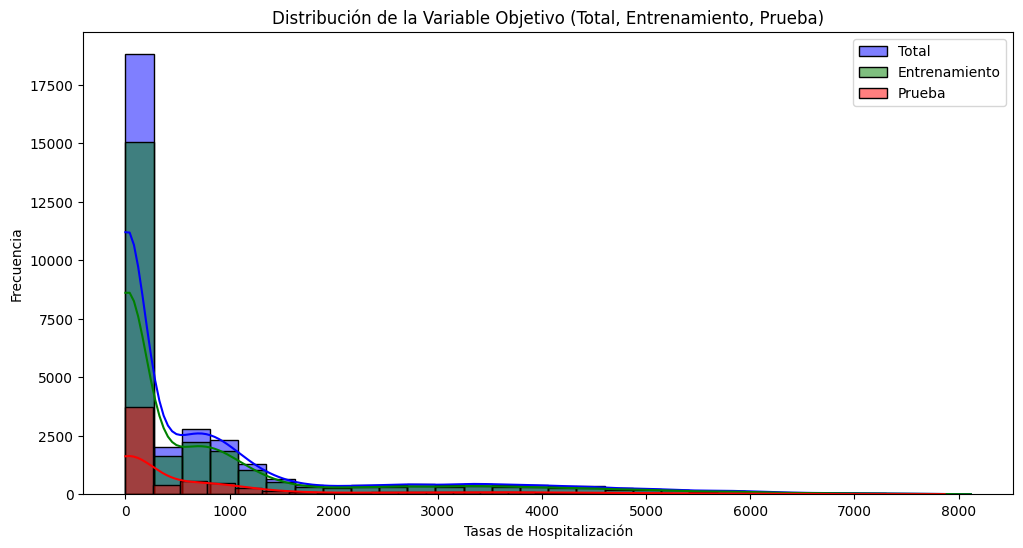

Tamaño del conjunto de entrenamiento: 26763
Tamaño del conjunto de prueba: 6691
Error Cuadrático Medio (MSE) del modelo base: 3.0405992627406877


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Número de características seleccionadas: 2
Error Cuadrático Medio (MSE) del modelo optimizado: 6.9128032001869535
Reducción del MSE tras la optimización: -3.872203937446266


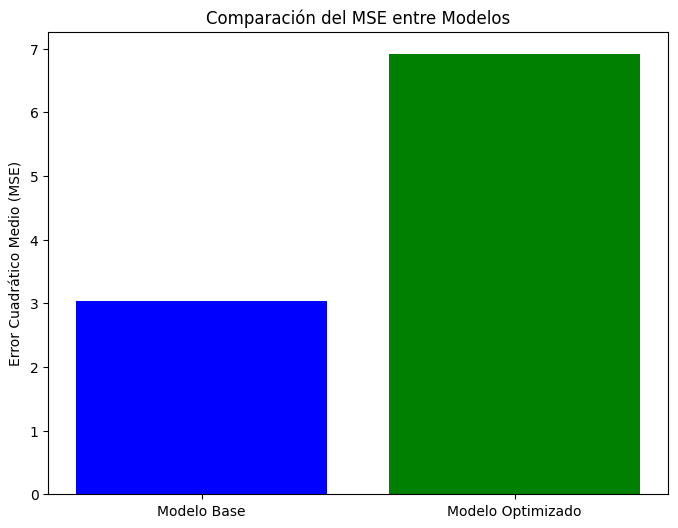

In [4]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import seaborn as sns

# Para cargar archivos desde tu computadora en Google Colab
from google.colab import files

#print("Por favor, selecciona los archivos a cargar:")
uploaded = files.upload()  # Esto abre un cuadro para seleccionar archivos

# Mostrar los nombres de los archivos cargados
for filename in uploaded.keys():
    print(f"Archivo cargado: {filename}")


# Cargar los datos (asegúrate de subir los archivos a Google Colab)
#excel_data = pd.ExcelFile("Medicare_Claims_Data.xlsx")
csv_data = pd.read_csv("Center_for_Medicare___Medicaid_Services__CMS____Medicare_Claims_data.csv")

# Unificar datasets en un solo DataFrame (si ambos tienen estructura similar)
try:
    df_excel = pd.concat([excel_data.parse(sheet) for sheet in excel_data.sheet_names])
    combined_data = pd.concat([df_excel, csv_data], ignore_index=True)
except Exception as e:
    combined_data = csv_data.copy()  # Si el Excel tiene menos estructura, usamos solo el CSV

# Verificar valores nulos y realizar imputación
combined_data.fillna(method='ffill', inplace=True)
combined_data.fillna(method='bfill', inplace=True)
combined_data.fillna(0, inplace=True)  # Valores restantes se rellenan con 0

# Eliminar columnas irrelevantes o con muchos nulos predefinidos
columns_to_drop = ['RowId', 'GeoLocation', 'PriorityArea2', 'PriorityArea4']
processed_data = combined_data.drop(columns=columns_to_drop, errors='ignore')

# Codificación de variables categóricas
label_encoders = {}
for column in processed_data.select_dtypes(include='object').columns:
    le = LabelEncoder()
    processed_data[column] = le.fit_transform(processed_data[column].astype(str))
    label_encoders[column] = le

# Separar características y variable objetivo
X = processed_data.drop(columns=['Data_Value'], errors='ignore')
y = processed_data['Data_Value']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Análisis de la división de los datos
plt.figure(figsize=(12, 6))
sns.histplot(y, bins=30, color="blue", label="Total", kde=True, alpha=0.5)
sns.histplot(y_train, bins=30, color="green", label="Entrenamiento", kde=True, alpha=0.5)
sns.histplot(y_test, bins=30, color="red", label="Prueba", kde=True, alpha=0.5)
plt.title("Distribución de la Variable Objetivo (Total, Entrenamiento, Prueba)")
plt.xlabel("Tasas de Hospitalización")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de prueba:", len(X_test))

# Entrenamiento del modelo Random Forest inicial
baseline_model = RandomForestRegressor(random_state=42, n_estimators=100)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

# Calcular MSE del modelo base
baseline_mse = mean_squared_error(y_test, y_pred)
print("Error Cuadrático Medio (MSE) del modelo base:", baseline_mse)

# Optimización de características con Lasso
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Selección de características importantes
sfm = SelectFromModel(lasso, prefit=True)
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

print("Número de características seleccionadas:", X_train_selected.shape[1])

# Reentrenamiento del modelo con características seleccionadas
optimized_model = RandomForestRegressor(random_state=42, n_estimators=100)
optimized_model.fit(X_train_selected, y_train)
y_pred_optimized = optimized_model.predict(X_test_selected)

# Calcular MSE del modelo optimizado
optimized_mse = mean_squared_error(y_test, y_pred_optimized)
print("Error Cuadrático Medio (MSE) del modelo optimizado:", optimized_mse)

# Comparación de resultados
print("Reducción del MSE tras la optimización:", baseline_mse - optimized_mse)

# Gráfico de comparación de MSE
plt.figure(figsize=(8, 6))
plt.bar(['Modelo Base', 'Modelo Optimizado'], [baseline_mse, optimized_mse], color=['blue', 'green'])
plt.title('Comparación del MSE entre Modelos')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.show()

